#  Benchmarking class-out-of-distribution performance

In this example we will see how to use our framework to benchmark C-OOD performance.

To use the dataset from our paper (a subset of ImageNet-21k), first download ImageNet-21k in its entirety and use the *get_paper_dataset_info(path_to_ImageNet21k)* to trasnform it into our filtered version of the data.

## The basics

In [1]:
from cood_uncertainty_lib import benchmark_model_on_cood_with_severities
import plotly.express

Using our framework to benchmark a model is as easy as using four lines of code:
```
    paper_dataset_ood = get_paper_ood_dataset_info(path_to_full_imagenet21k, skip_scan=True)
    paper_dataset_id = get_paper_id_dataset_info(path_to_full_imagenet1k, skip_scan=False)
    
    results = benchmark_model_on_cood_with_severities(model='resnet50', cood_dataset_info=paper_dataset_ood,
                                                    id_dataset_info=paper_dataset_id))
    plotly.express.line(results, x='severity_levels', y='cood-auroc', color='model_name-kappa')
```

The above code will benchmark a pretrained ResNet-50 available in the timm repo ( https://github.com/rwightman/pytorch-image-models ) on ImageNet (the code is able to benchmark custom models as well, see below) and will plot its "degradation graph" (identical to Figure 1 from the paper).

To save compute, in this example we will benchmark models on a smaller dummy dataset.
To do that, we first need to define our custom dataset that consists of an ID part (in the complete dataset this part is made of classes from ImageNet-1k) and an OOD part (in the complete dataset this part is a filtered version of ImageNet-21k without the classes from ImageNet-1k):

In [2]:
from download_dummy_dataset import download_dummy_dataset
download_dummy_dataset('./dummy_dataset')

100% |########################################################################|


Extracting dataset into ./dummy_dataset
Dummy dataset downloaded successfully.
You can find the dataset at: ./dummy_dataset
In-distribution component of the dummy dataset path: ./dummy_dataset\dummy_id
Class-out-of-distribution component of the dummy dataset path:./dummy_dataset\dummy_ood


In [3]:
# <path to images dir>/classname/*.(jpg|png|jpeg)
dummy_ood_dataset_info = {
    'dataset_name': 'Dummy_OOD',
    'images_base_folder': './dummy_dataset/dummy_ood',  
    'test_estimation_split_percentage': 0.25
}

dummy_id_dataset_info = {
    'dataset_name': 'Dummy_ID',
    'images_base_folder': './dummy_dataset/dummy_id',
}

The 'dataset_name' value is used to name the metadata of the dataset. The metadata is helpful in saving compute for using the dataset.

'test_estimation_split_percentage' defines the split between the amount of the OOD data used to estimate each class' severity (hardness) score and the amount used for testing its performance. For ImageNet, we used 25% for testing (50 samples) vs 75% for estimation (150 samples).

Note that you can define your own custom datasets in a similar fashion.

Now let's use our custom dummy dataset and evaluate an ImageNet pretrained ResNet-18 model with softmax as its confidence function:

loaded dataset will have 33300 samples.
Evaluating with softmax as a confidence function. (Elapsed time:148.262 sec): 100%|██| 521/521 [02:28<00:00,  3.50it/s]
loaded dataset will have 11600 samples.
Evaluating with softmax as a confidence function. (Elapsed time:41.070 sec): 100%|███| 182/182 [00:41<00:00,  4.39it/s]


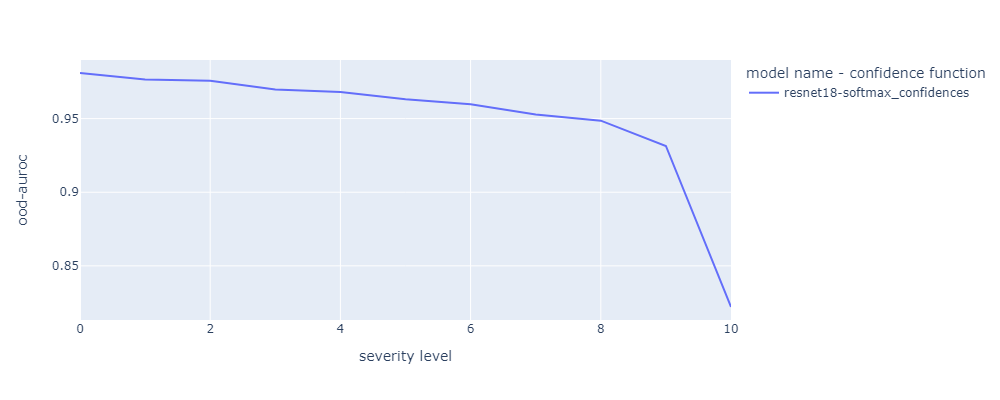

In [4]:
results = benchmark_model_on_cood_with_severities(model='resnet18',
                                                    confidence_function='softmax',
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info)
fig = plotly.express.line(results, x='severity level', y='ood-auroc', color='model name - confidence function')

fig.update_layout(width=1000, height=400)
fig.show('png')
# Unfortunately, github doesn't load plotly plots on notebooks. This is why we show them as png files.

The above plot is a 'degradation graph', showing the model's performance in AUROC (y axis) across different severity levels (x axis).

Note that after running this code snippet, a new results csv was added at .\results\resnet18\Dummy_OOD-Dummy_ID\resnet18_softmax_n11.csv

- The code first checks whether or not results for this specific combination of *(model, confidence function)* already exist.

We can also evaluate and compare different models at the same time.
For example, suppose we want to compare two models, ResNet-18 and ResNet-34, each equipped with either softmax or entropy as its confidence function.

In this case, we can pass lists containing the models and lists containing the confidence functions (instead of just passing one string), as follows:

loaded dataset will have 33300 samples.
Evaluating with entropy as a confidence function. (Elapsed time:109.687 sec): 100%|██| 521/521 [01:50<00:00,  4.74it/s]
loaded dataset will have 11600 samples.
Evaluating with entropy as a confidence function. (Elapsed time:39.915 sec): 100%|███| 182/182 [00:40<00:00,  4.52it/s]


loaded dataset will have 33300 samples.
Evaluating with softmax as a confidence function. (Elapsed time:115.313 sec): 100%|██| 521/521 [01:55<00:00,  4.51it/s]
loaded dataset will have 11600 samples.
Evaluating with softmax as a confidence function. (Elapsed time:40.008 sec): 100%|███| 182/182 [00:40<00:00,  4.51it/s]
loaded dataset will have 33300 samples.
Evaluating with entropy as a confidence function. (Elapsed time:109.680 sec): 100%|██| 521/521 [01:49<00:00,  4.74it/s]
loaded dataset will have 11600 samples.
Evaluating with entropy as a confidence function. (Elapsed time:40.066 sec): 100%|███| 182/182 [00:40<00:00,  4.51it/s]


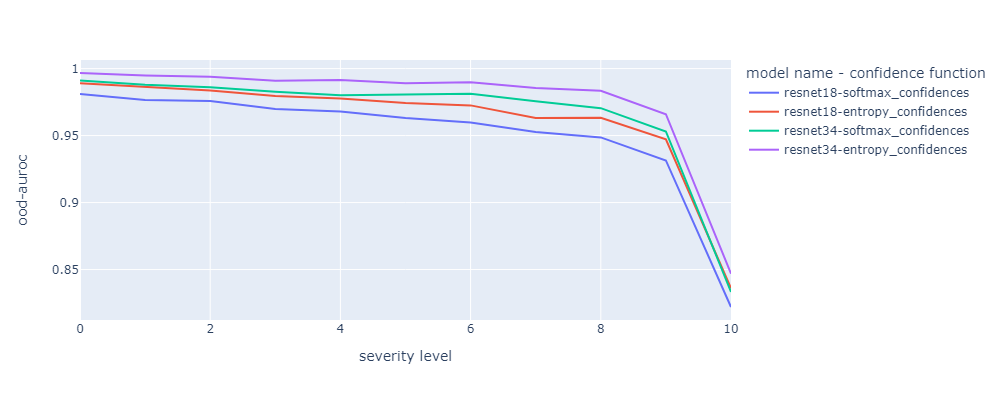

In [5]:
results = benchmark_model_on_cood_with_severities(model=['resnet18', 'resnet34'],
                                                    confidence_function=['softmax', 'entropy'],
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info)
fig = plotly.express.line(results, x='severity level', y='ood-auroc', color='model name - confidence function')

fig.update_layout(width=1000, height=400)
fig.show('png')

Note that since we've already evaluated ResNet-18 with a softmax confidence function before, the same results were used for this current comparison rather than being calculated again.

## Evaluating custom models and confidence functions

**Evaluating custom models:**
There are a number of ways to pass the model to the *benchmark_model_on_cood_with_severities* method.
- If it is a 'timm' model, its matching string name could be passed (as seen in the examples above).
- Otherwise, the method expects a dictionary like the one in the example below:

loaded dataset will have 33300 samples.
Evaluating with softmax as a confidence function. (Elapsed time:132.991 sec): 100%|██| 521/521 [02:13<00:00,  3.91it/s]
loaded dataset will have 11600 samples.
Evaluating with softmax as a confidence function. (Elapsed time:49.779 sec): 100%|███| 182/182 [00:50<00:00,  3.63it/s]


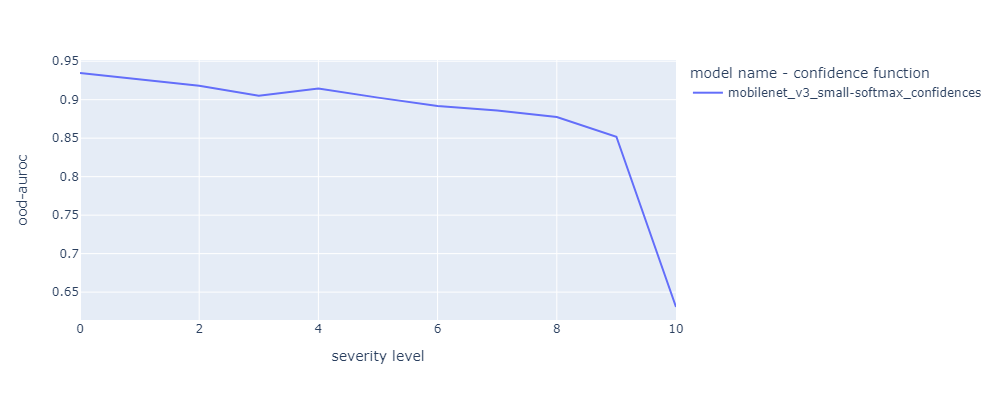

In [6]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

weights = MobileNet_V3_Small_Weights.DEFAULT
transforms = weights.transforms()

model = mobilenet_v3_small(weights=weights)

example_model_input = {'model_name': 'mobilenet_v3_small', 'model': model, 'transforms': transforms}
results = benchmark_model_on_cood_with_severities(model=example_model_input,
                                                    confidence_function='softmax',
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info)
fig = plotly.express.line(results, x='severity level', y='ood-auroc', color='model name - confidence function')

fig.update_layout(width=1000, height=400)
fig.show('png')

The *'model_name'* argument defines the name for the directory into which the results will be saved in ./models_results

**Evaluating custom confidence functions:**
We've implemented the following confidence functions in utils/confidence_functions.py:
- Softmax response
- Entropy
- Max logit
- ODIN [1]
- MC Dropout [2]

Additional confidence functions could be defined and passed as an argument for *'benchmark_model_on_cood_with_severities'*. 
The easiest way to define custom confidence functions is using *extract_custom_confidence_function_on_dataset*, defined in utils/confidence_functions, and pass to it your own custom confidence function.

Your custom function should get a model and images as input, and return the model's logits and confidence scores as an output.

Finally, similarly to when we passed custom models, we define a dictionary containing all information about our confidence function and then pass it to *benchmark_model_on_cood_with_severities* as an argument.


In the following code snippets we show how to define our own custom softmax response as a confidence function:

In [7]:
import torch
def custom_softmax_confidence_function(model, x):
    logits = model(x)
    probs = torch.nn.functional.softmax(logits, dim=1)
    softmax_conf, _ = torch.max(probs, dim=1)
    return logits, softmax_conf

loaded dataset will have 33300 samples.
Evaluating with softmax as a confidence function. (Elapsed time:115.852 sec): 100%|██| 521/521 [01:56<00:00,  4.48it/s]
loaded dataset will have 11600 samples.
Evaluating with softmax as a confidence function. (Elapsed time:44.861 sec): 100%|███| 182/182 [00:45<00:00,  4.03it/s]


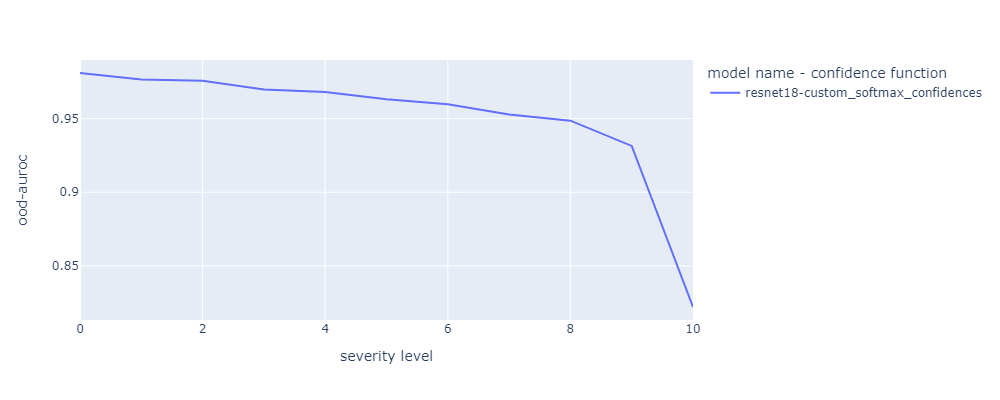

In [8]:
from utils.confidence_functions import extract_custom_confidence_function_on_dataset
import functools

custom_softmax = functools.partial(extract_custom_confidence_function_on_dataset, 
                                   confidence_function=custom_softmax_confidence_function)
custom_confidence_function = {'confidence_metric_name': 'custom_softmax', 
                              'confidence_metric_callable': custom_softmax}
results = benchmark_model_on_cood_with_severities(model='resnet18',
                                                    confidence_function=custom_confidence_function,
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info)
fig = plotly.express.line(results, x='severity level', y='ood-auroc', color='model name - confidence function')

fig.update_layout(width=1000, height=400)
fig.show('png')

We can define multiple custom confidence functions and compare them.
In the example below we define an inverse-softmax function as our custom confidence function, and compare its performance to softmax:

In [9]:
def custom_inverse_softmax_confidence_function(model, x):
    logits = model(x)
    probs = torch.nn.functional.softmax(logits, dim=1)
    softmax_conf, _ = torch.max(probs, dim=1)
    return logits, -softmax_conf

loaded dataset will have 33300 samples.
Evaluating with softmax as a confidence function. (Elapsed time:113.807 sec): 100%|██| 521/521 [01:54<00:00,  4.57it/s]
loaded dataset will have 11600 samples.
Evaluating with softmax as a confidence function. (Elapsed time:40.362 sec): 100%|███| 182/182 [00:40<00:00,  4.47it/s]


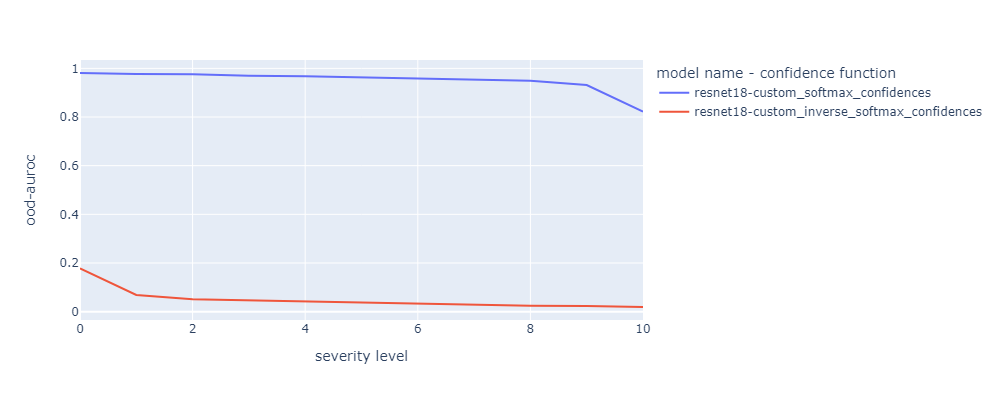

In [10]:
custom_inverse_softmax = functools.partial(extract_custom_confidence_function_on_dataset, 
                                   confidence_function=custom_inverse_softmax_confidence_function)
custom_confidence_function2 = {'confidence_metric_name': 'custom_inverse_softmax', 
                              'confidence_metric_callable': custom_inverse_softmax}
results = benchmark_model_on_cood_with_severities(model='resnet18',
                                                    confidence_function=[custom_confidence_function, 
                                                                         custom_confidence_function2],
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info)
fig = plotly.express.line(results, x='severity level', y='ood-auroc', color='model name - confidence function')

fig.update_layout(width=1000, height=400)
fig.show('png')

The examples above were trivial (softmax and inverse softmax), but a more sophisticated confidence function (like ODIN) could also be implemented easily.

Finally, if your confidence function requires more advanced features to work, you can define your own custom confidence function similarly to how we defined the existing functions in utils/confidence_functions.py.

In the following code snippet we use *'extract_softmax_on_dataset'* as an example for a possible confidence function to be defined:

loaded dataset will have 33300 samples.
Evaluating with softmax as a confidence function. (Elapsed time:111.139 sec): 100%|██| 521/521 [01:51<00:00,  4.67it/s]
loaded dataset will have 11600 samples.
Evaluating with softmax as a confidence function. (Elapsed time:40.468 sec): 100%|███| 182/182 [00:40<00:00,  4.46it/s]


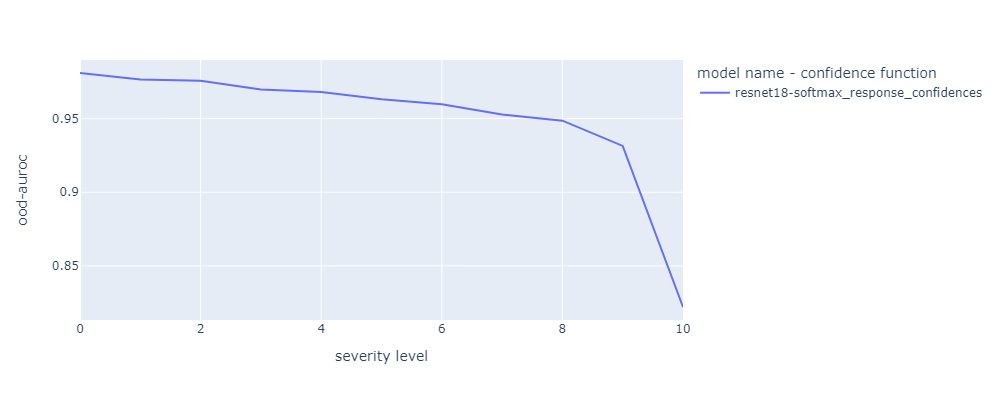

In [11]:
from utils.confidence_functions import extract_softmax_on_dataset
custom_confidence_function = {'confidence_metric_name': 'softmax_response', 
                              'confidence_metric_callable': extract_softmax_on_dataset}
results = benchmark_model_on_cood_with_severities(model='resnet18',
                                                    confidence_function=custom_confidence_function,
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info)
fig = plotly.express.line(results, x='severity level', y='ood-auroc', color='model name - confidence function')

fig.update_layout(width=1000, height=400)
fig.show('png')

## Advanced tricks

**Evaluating specific severity levels:** If we want to make a similar comparison but we're only interested in specific severity levels, for example, 8-10, we can pass the desired levels as an argument to the method:

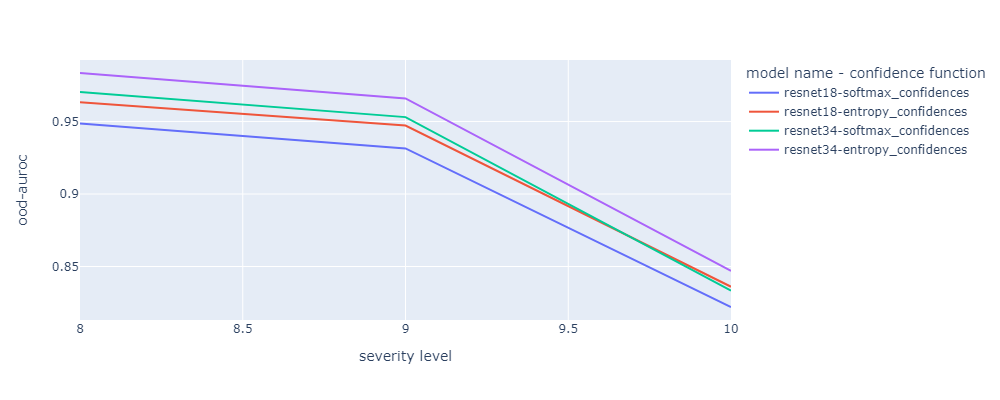

In [12]:
results = benchmark_model_on_cood_with_severities(model=['resnet18', 'resnet34'],
                                                    confidence_function=['softmax', 'entropy'],
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info,
                                                    levels_to_benchmark=[8,9,10])
fig = plotly.express.line(results, x='severity level', y='ood-auroc', color='model name - confidence function')

fig.update_layout(width=1000, height=400)
fig.show('png')

**Evaluating a custom number of severity levels:**
In the paper we have used 11 severity levels for analysis, but we can define less \ more levels to be used. This is done using the 'num_severity_levels' argument: 

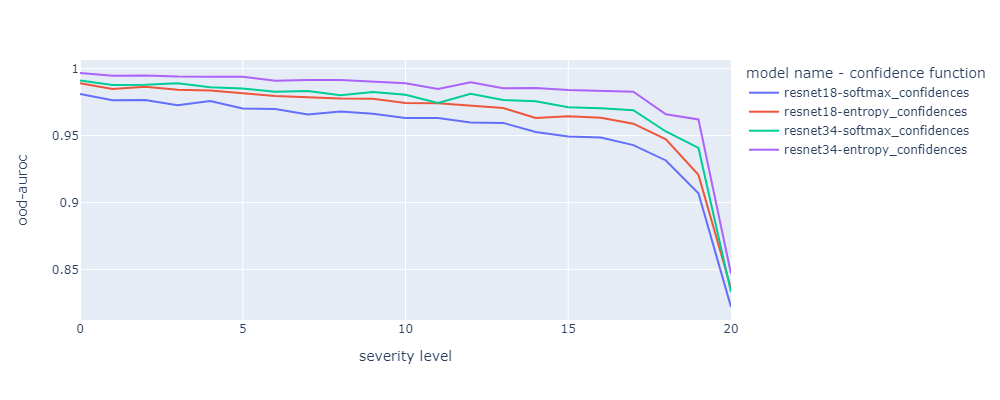

In [13]:
results = benchmark_model_on_cood_with_severities(model=['resnet18', 'resnet34'],
                                                    confidence_function=['softmax', 'entropy'],
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info,
                                                    num_severity_levels=21)
fig = plotly.express.line(results, x='severity level', y='ood-auroc', color='model name - confidence function')

fig.update_layout(width=1000, height=400)
fig.show('png')

Note that using a different number of severity levels changes the statistical interpretation of each severity level. In the above example the median severity is severity level 10 (while in the original 11 levels of severity, the median was severity level 5).

## Loading paper results for 520 models on ImageNet

You can easily load and compare results for the 520 ImageNet classifiers we have evaluated in the paper (using a filtered version of ImageNet-21k, see Section 4 in the paper). Here is an example of how to do this using the *get_paper_results* method:

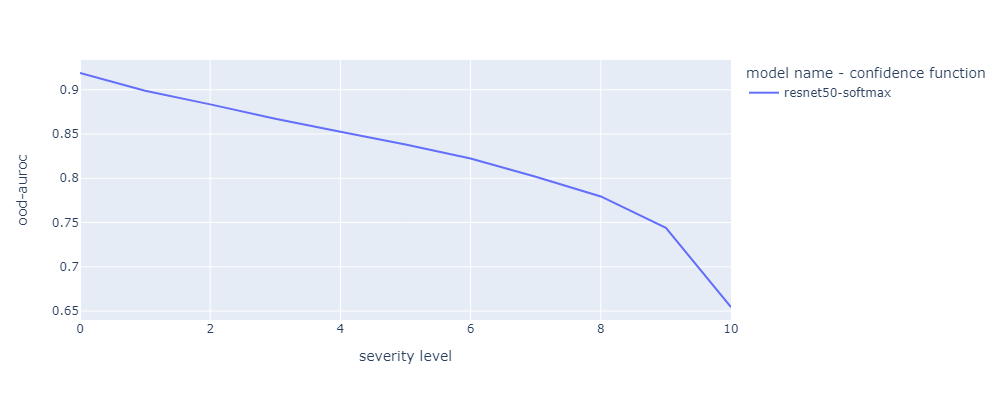

In [14]:
from cood_uncertainty_lib import get_paper_results
results = get_paper_results(model_name='resnet50', confidence_function='softmax')
fig = plotly.express.line(results, x='severity level', y='ood-auroc', color='model name - confidence function')

fig.update_layout(width=1000, height=400)
fig.show('png')

Similarly, different models with different confidence functions could be evaluated as follows:

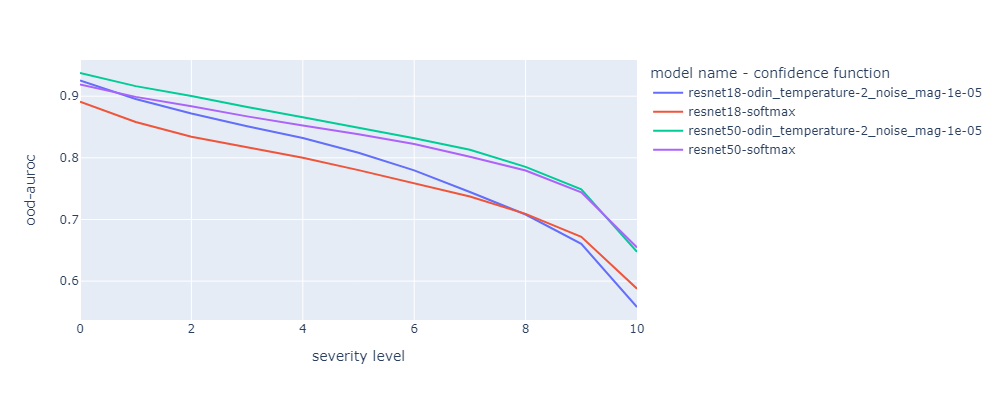

In [15]:
results = get_paper_results(model_name=['resnet50', 'resnet18'], confidence_function=['softmax', 'odin'])
fig = plotly.express.line(results, x='severity level', y='ood-auroc', color='model name - confidence function')

fig.update_layout(width=1000, height=400)
fig.show('png')

Finally, calling *get_paper_results()* with no arguments will return results for **all** combinations of *(model, confidence function)* evaluated in the paper.

## Using our benchmark with ImageNet

As mentioned at the beginning of this notebook, to use the dataset from our paper (a subset of ImageNet-21k), first download ImageNet-21k in its entirety and use the *get_paper_dataset_info(path_to_ImageNet21k)* to trasnform it into our filtered version of the data.
Define the ID dataset to be ImageNet-1k entire validation set.
Finally, use the same code as we've seen above to evaluate with these datasets.
For example:

```
from cood_uncertainty_lib import benchmark_model_on_cood_with_severities, get_paper_ood_dataset_info, \
    get_paper_id_dataset_info

path_to_imagenet1k = 'D:\ImageNet_1K\ILSVRC2012_img_val'  # path to ImageNet-1k validation set (ILSVRC2012_img_val)
paper_id_dataset = get_paper_id_dataset_info(path_to_imagenet1k, skip_scan=False)

path_to_imagenet21k = 'D:\fall11_whole'  # path to ImageNet-21k (fall11_whole)
paper_ood_dataset = get_paper_ood_dataset_info(path_to_imagenet21k, skip_scan=True)


results = benchmark_model_on_cood_with_severities(model='resnet18',
                                                    confidence_function='softmax',
                                                    cood_dataset_info=paper_id_dataset,
                                                    id_dataset_info=paper_ood_dataset)
```

* When loading the paper's dataset with *get_paper_ood_dataset_info* \ *get_paper_id_dataset_info*, the method scans the dataset to validate its integrity by default. This might take some time, *get_paper_ood_dataset_info* especially. The argument *skip_scan* controls whether or not to make this scan. We recommend leaving it "*False*" the first time loading these datasets, and then turning it to "*True*" for subsequent runs. 


* You can also download our filtered version of ImageNet-21k directly and load it using the instructions found in the "Instructions for downloading and extracting our filtered version of ImageNet-21k" section of the Git's readme.

## References

[1] Shiyu Liang, et al. *Enhancing The Reliability of Out-of-distribution Image Detection in Neural Networks*, ICLR 2018

[2] Yarin Gal, et al. *Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning*, ICML 2015